# DLMI PROJECT : Low-Dose CT Image Denoising

Authors :
- JOEL MBOUWE
- ADNAN ZEDDOUN 
- ABDER MEHDAOU

# Données et packages


In [2]:
# %%shell
# mkdir imgs && cd imgs
# wget https://zenodo.org/record/3384092/files/ground_truth_validation.zip
# unzip -q ground_truth_validation.zip
# rm ground_truth_validation.zip
# wget https://zenodo.org/record/3384092/files/ground_truth_test.zip
# unzip -q ground_truth_test.zip
# rm ground_truth_test.zip

# Pour le projet

In [1]:
import h5py
import matplotlib.pyplot as plt
from IPython import display
# from utils import Logger
# Pytorch Libraries
import torch
import torchvision as tv
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# General Libraries
import os
import zipfile
import h5py
import time
import torchvision.models as models
# Modelisation Libraries
import numpy as np
from PIL import Image
from tqdm import tqdm
from glob import glob

import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize

from IPython import display
# from utils import Logger
import torch
from torch import nn, optim
from torch import autograd
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

%load_ext autoreload
%matplotlib inline

In [2]:
dim = 64
out_shape = 8 

In [3]:
name_list1 = ['ground_truth_validation/ground_truth_validation_00' + str(i)+ '.hdf5' for i in range(10)]
name_list2 = ['ground_truth_validation/ground_truth_validation_0' + str(i)+ '.hdf5' for i in range(10,27)]
name_list = name_list1 + name_list2
X_train = [h5py.File(i, 'r')['data'] for i in name_list]
name_list1_test = ['ground_truth_test/ground_truth_test_00' + str(i)+ '.hdf5' for i in range(10)]
name_list2_test = ['ground_truth_test/ground_truth_test_0' + str(i)+ '.hdf5' for i in range(10,27)]
name_list_test = name_list1_test + name_list2_test
X_test = [h5py.File(i, 'r')['data'] for i in name_list_test]
X_train = X_train + X_test

In [4]:
img_list =  []
for k in range(49) :
  for i in range(128) :
    img_list.append(X_train[k][i])
val_list =  []
for k in range(49, 54) :
  for i in range(128) :
    val_list.append(X_train[k][i])
print(len(val_list))
print(len(img_list))

640
6272


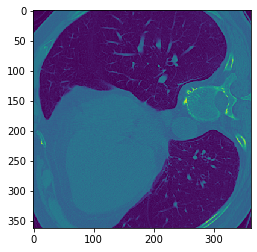

In [5]:
plt.imshow(X_train[0][26])

In [6]:
class NoisyDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_list, data_augmentation_factor, mu, var, transforms=True, only_noise=False, name="train"):
        """
        Arguments:
            - img_list: list of the images paths
            - data_augmentation_factor: int - number of times an image is augmented. Set
            it to 0 if no augmentation is wanted.
            - mu: mean of the training set - used for standardization
            - var: standard deviation of the training set - used for standardization
            - transforms: bool - indicates whether to apply data augmentation 
            - name: string - name of the dataset (train, validation or test)
            - only_noise: bool - whether or not to do residual learning
        """
        np.random.seed(0)
                
        if not data_augmentation_factor: self.data_augmentation_factor = 1
        else: self.data_augmentation_factor = data_augmentation_factor
        self.img_list = img_list
        self.transforms = transforms
        self.only_noise = only_noise
        self.name = name        
        self.mean = mu
        self.std = var

        # Create dictionary that maps each image to some specific noise and the
        # image's path
        dicts = []
        for image_path in img_list:
            for _ in range(self.data_augmentation_factor):

                # Define noise to be applied
                p = np.random.rand()
                if p < 1: noise_type = "gaussian"
                else: noise_type ="speckle"

                # Add image-noise pair information to the info dictionary
                dicts.append({'path': image_path,
                              'noise': noise_type})            
        self.img_dict = {image_id: info for image_id, info in enumerate(dicts)}


    def __getitem__(self, image_id):
        np.random.seed(0)

        #load image
        #img = imageio.imread(self.img_dict[image_id]['path']).astype(np.uint8)
        img = self.img_dict[image_id]['path']
        #standardize it
#         img = (img - img.min()) /(img.max() - img.min())
        #downsample the images' size (to speed up training)
        img = resize(img, (dim, dim))

        #create noisy image 
        noise_type = self.img_dict[image_id]['noise']       
        if noise_type == "gaussian":
            noise = np.random.normal(0, 0.015, img.shape)
        elif noise_type == "speckle":  
            noise =  img * np.random.randn(img.shape[0], img.shape[1]) / 5            
        noisy_img = img + noise
        noisy_img = (noisy_img - noisy_img.min()) /(noisy_img.max() - noisy_img.min())
        #if residual learning, ground-truth should be the noise
        if self.only_noise: img = noise

        #convert to PIL images
        img = Image.fromarray(img)
        noisy_img = Image.fromarray(noisy_img)

        #apply the same data augmentation transformations to the input and the 
        #ground-truth
        p = np.random.rand()
        if self.transforms and p<0.5: 
            self.t = T.Compose([T.RandomHorizontalFlip(1), T.ToTensor()])
        else: self.t = T.Compose([T.ToTensor()])
        img = self.t(img)
        noisy_img = self.t(noisy_img)
        return noisy_img, img

    def __len__(self):
        return len(self.img_dict)

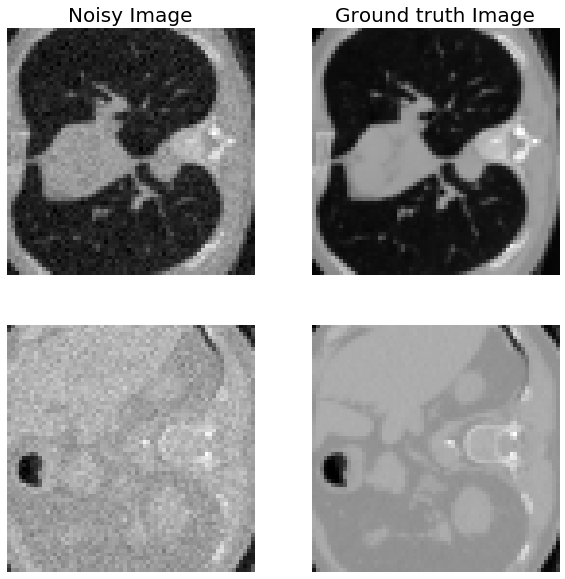

In [59]:
x, y = train[110]
x1, y1 = train[150]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
axes[0].imshow(x[0], cmap="gray")
axes[0].axis('off')
axes[0].set_title('Noisy Image', fontsize=20)
# plt.subplot(122)
axes[1].imshow(y[0], cmap="gray")
axes[1].axis('off')
axes[1].set_title('Ground truth Image', fontsize=20)
# plt.subplot(221)
axes[2].imshow(x1[0], cmap="gray")
axes[2].axis('off')
# plt.subplot(222)
axes[3].imshow(y1[0], cmap="gray")
axes[3].axis('off')
plt.show()

In [61]:
fig.savefig('sample', dpi = 100, bbox_inches='tight')

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    """ FILL HERE """
    self.convlayers = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
    )

  def forward(self,x):
    x = self.convlayers(x)
    return x

In [11]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=3, 
                stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3,
                stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3,
                stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=128, kernel_size=3,
                stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=3,
                stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=256, kernel_size=3,
                stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )     

        self.linear = nn.Sequential(
            torch.nn.Linear(256 * out_shape**2, 1024),
            nn.LeakyReLU(inplace=True)
        )           
        self.out = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        # Flatten and apply sigmoid
#         print(x.shape)
        x = x.view(-1, 256 * out_shape**2)
        x = self.linear(x)
        x = self.out(x)
        return x

In [12]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = models.vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, x):
        x = x*255.0
        x = x.repeat(1, 3, 1, 1)
        x[:, 0,:,:]-=103.939
        x[:, 1,:,:]-=116.779
        x[:, 2,:,:]-=123.68
        out = self.feature_extractor(x)
        return out
features_extractor = FeatureExtractor()
for param in features_extractor.parameters():
    param.requires_grad = False

In [13]:
Lambda = 10
batch_size = 32
num_epochs = 100

In [14]:
only_noise = False
train = NoisyDataset(img_list, 1, 0, 1, False, only_noise, name="train")
val = NoisyDataset(val_list, 1, 0, 1, False, only_noise, name="validation")

In [15]:
torch.manual_seed(1)
data_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=2)

val_data_loader = torch.utils.data.DataLoader(
    val, batch_size=2, shuffle=False, num_workers=2)

In [16]:
generator = Generator()
discriminator = Discriminator()
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    features_extractor.cuda()
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=1e-5, betas=(0.5, 0.999))

In [17]:
def vgg_loss(pred, gt, features_extractor = features_extractor):
  #vgg_pred = features_extractor(pred)
  vgg_gt = features_extractor(gt) 
  vgg_pred = features_extractor(pred)
  size = vgg_gt.shape
#   normalized = 1/(size[1]*size[2]*size[3])
  mse = nn.MSELoss()
  return mse(vgg_pred, vgg_gt)

In [20]:
def calc_gradient_penalty(discriminator, real_data, fake_data, Lambda, batch_size=16):

    alpha = torch.rand(real_data.shape[0], 1).cuda()
    alpha = alpha.expand(real_data.shape[0], int(real_data.nelement()/real_data.shape[0])).contiguous()
    alpha = alpha.view(real_data.shape[0], 1, dim, dim)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.requires_grad_(True)

    disc_interpolates = discriminator(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * Lambda
    return gradient_penalty

def train_discriminator_generator(optimizer_d, optimizer_g, real_data, input_img,
                                  batch_size, loss_function, Lambda=10, lambda_2=10):

   # real_data = Normal DCT & input_img = Low DTC
    #1. Train Discriminator
    #Reset gradients
    fake_data = generator(input_img)
    for k in range(2) :
      optimizer_d.zero_grad()
      #1.1 Train on Real Data
      prediction_real = discriminator(real_data)
      # Calculate error and backpropagate
      error_real = -torch.mean(prediction_real)

      # 1.2 Train on Fake Data
      prediction_fake = discriminator(fake_data.detach())
      # Calculate error and backpropagate
      error_fake = torch.mean(prediction_fake)
      gradient_penalty = calc_gradient_penalty(discriminator, real_data, 
                                              fake_data.detach(), Lambda=Lambda,
                                              batch_size=batch_size)

      loss_discriminator = error_real + error_fake
      loss_discriminator.backward()
      gradient_penalty.backward()

      # 1.3 Update weights with gradients
      optimizer_d.step()

    # 2. Train Generator
    # Reset gradients
    optimizer_g.zero_grad()
    # generate fake data
#     fake_data = generator(input_img)
    prediction_img = discriminator(fake_data)
    # Calculate error and backpropagate
    loss_generator = -torch.mean(prediction_img) 
    loss_vgg = lambda_2 * loss_function(fake_data, real_data)
    loss_generator_t = loss_generator + loss_vgg 
    loss_generator_t.backward()
    # Update weights with gradients
    optimizer_g.step()   

    # print(loss_discriminator, loss_generator, loss_vgg, gradient_penalty)
    return loss_discriminator, loss_generator, loss_vgg, gradient_penalty, error_real.mean(), error_fake.mean(), fake_data
def validate_discriminator_generator(real_data, input_img,
                                    batch_size, loss_function,
                                     Lambda=10, lambda_2=10):

   # real_data = Normal DCT & input_img = Low DTC
    fake_data = generator(input_img)
    prediction_real = discriminator(real_data)
    error_real = -torch.mean(prediction_real)
    prediction_fake = discriminator(fake_data.detach())
    error_fake = torch.mean(prediction_fake)
    gradient_penalty = calc_gradient_penalty(discriminator, real_data, 
                                              fake_data.detach(), Lambda=Lambda,
                                              batch_size=batch_size)

    loss_discriminator = error_real + error_fake
    loss_generator = - error_fake
    loss_vgg = lambda_2 * loss_function(fake_data, real_data)

    return loss_discriminator, loss_generator, loss_vgg, gradient_penalty, error_real.mean(), error_fake.mean(), fake_data

In [21]:
for n_batch, (test_images, real_test_img) in enumerate(val_data_loader) :
    if n_batch ==1:
        break
input_test_img = test_images.cuda()
real_test_img = real_test_img.cuda()

In [18]:
def plot_prediction(inputs, outputs, ground_truth, only_noise, plot=False, epoch='0'):
    size = inputs.shape
    inputs = np.vstack(inputs.data.cpu().numpy().reshape(size[0], size[2], size[3]))
    outputs = np.vstack(outputs.data.cpu().numpy().reshape(size[0], size[2], size[3]))
    ground_truth = np.vstack(ground_truth.data.cpu().numpy().reshape(size[0], size[2], size[3]))
    for i in range(1):
        fig = plt.figure(figsize=(20, 15))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax1.set_title("Noisy image")
        ax2.set_title("Denoised image")
        ax3.set_title("Ground-truth")       

        if only_noise:
            ax1.imshow(inputs, cmap='gray')
            ax2.imshow(inputs - outputs[0], cmap='gray')
            ax3.imshow(inputs - ground_truth[0], cmap='gray')
        else:
            ax1.imshow(inputs, cmap='gray')
            ax2.imshow(outputs, cmap='gray')
            ax3.imshow(ground_truth, cmap='gray')
        if plot: plt.show()
        fig.savefig("images/epoch_" + epoch, dpi = 200)

def display_status(epoch, num_epochs, n_batch, 
                    p_real, loss_vgg, p_fake, penalty,
                    batch_ = int(len(data_loader.dataset)/batch_size)) :
  print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
  epoch, num_epochs, n_batch, batch_))
  print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
  print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(p_real, p_fake))
  print('Loss VGG : {:.4f}'.format(loss_vgg.data.cpu()))
  print('Gradient penalty : {:.4f}'.format(penalty.data.cpu()))

In [19]:
import gc; gc.collect()

4587

In [20]:
def MSE(image_true, image_generated):
    return ((image_true - image_generated) ** 2).mean()


def PSNR(image_true, image_generated):
    mse = MSE(image_true, image_generated)
    return -10 * torch.log10(mse)


def SSIM(image_true, image_generated, C1=0.01, C2=0.03):
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = ((image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = (mean_true ** 2 + mean_generated ** 2 + C1) * (std_true ** 2 + std_generated ** 2 + C2)
    return numerator / denominator

sd

## Entraînement du modèle

In [25]:
loss_function = {'d_error' : {'train' : [], 'test' : []},
                 'g_error' : {'train' : [], 'test' : []},
                 'loss_vgg' : {'train' : [], 'test' : []},
                 'penalty' : {'train' : [], 'test' : []},
                 'p_real' : {'train' : [], 'test' : []},
                 'p_fake' : {'train' : [], 'test' : []},
                'PSNR' : {'train' : [], 'test' : []},
                'SSIM' : {'train' : [], 'test' : []}}
def update_loss_function(d_error, g_error, loss_vgg, 
                         penalty , p_real, p_fake, psnr, ssim, mode) :
    loss_function['d_error'][mode].append(d_error.data.cpu().numpy().reshape(1)[0])
    loss_function['g_error'][mode].append(g_error.data.cpu().numpy().reshape(1)[0])
    loss_function['loss_vgg'][mode].append(loss_vgg.data.cpu().numpy().reshape(1)[0])
    loss_function['penalty'][mode].append(penalty.data.cpu().numpy().reshape(1)[0])
    loss_function['p_real'][mode].append(-p_real.data.cpu().numpy().reshape(1)[0])
    loss_function['p_fake'][mode].append(p_fake.data.cpu().numpy().reshape(1)[0])
    loss_function['PSNR'][mode].append(psnr.data.cpu().numpy().reshape(1)[0])
    loss_function['SSIM'][mode].append(ssim.data.cpu().numpy().reshape(1)[0])

In [27]:
name = '_wgan_vgg'

In [ ]:
for epoch in range(num_epochs):
    for n_batch, (input_img, real_data) in enumerate(data_loader):
        real_data = Variable(real_data)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        if torch.cuda.is_available(): input_img = input_img.cuda()
        # Train D & G
        d_error, g_error, loss_vgg, penalty , p_real, p_fake, pred_images = train_discriminator_generator(d_optimizer, 
                                                         g_optimizer,
                                                         real_data,
                                                         input_img,
                                                         loss_function=vgg_loss,
                                                         batch_size=batch_size)
        
#         pred_images = generator(input_img)
#         g_optimizer.zero_grad()
#         loss_vgg = nn.MSELoss()(pred_images, real_data); loss_vgg.backward()
#         g_optimizer.step()
        # Display Progress
        if (n_batch) % 120  == 0:
            display.clear_output(False)
            # Display Images
            psnr = PSNR(real_data, pred_images)
            ssim = SSIM(real_data, pred_images)
            update_loss_function(d_error, g_error, loss_vgg, 
                         penalty , p_real, p_fake, psnr, ssim, mode='train')
            d_error, g_error, loss_vgg_test, penalty , p_real, p_fake, pred_images = validate_discriminator_generator(real_test_img, input_test_img,
                                                                          batch_size=2, loss_function=vgg_loss)
#             pred_images = generator(input_test_img)
#             loss_vgg_test = nn.MSELoss()(real_test_img, pred_images)
            psnr = PSNR(real_test_img, pred_images)
            ssim = SSIM(real_test_img, pred_images)
            update_loss_function(d_error, g_error, loss_vgg_test, 
                         penalty, p_real, p_fake, psnr, ssim, mode='test')

#             pred_images = generator(input_test_img.cuda()).data.cpu()
            display_status(epoch, num_epochs + 10, n_batch, 
                    p_real, loss_vgg, p_fake, penalty, 
                    batch_ = int(len(data_loader.dataset)/batch_size)) 
            if epoch < 100 :
              epoch_ = '0' + str(epoch)
            else :
                epoch_ = epoch
            plot_prediction(input_test_img, pred_images, real_test_img, 
                            only_noise, plot=True, 
                            epoch= str(epoch_) + "_" + str(n_batch))
            gc.collect()

In [ ]:
fig, ax = plt.subplots(4, 2, figsize =(30, 20))
ax = ax.flatten()
i = 0
for key, values in loss_function.items() :
#     if key in ['SSIM', 'loss_vgg', 'PSNR']:
    ax[i].plot(values['test'][2:], label='test')
    ax[i].plot(values['train'][2:], label='train')
    ax[i].set_title(key)
    ax[i].legend(loc='best')
    i = i+1

In [35]:
torch.save(generator.state_dict(), 'generator'+ name)
torch.save(discriminator.state_dict(), 'discriminator' + name)
np.save(name, loss_function) 
fig.savefig('loss_gen' + name +'.png')

# Evaluation des différents modèles

In [84]:
path_models = ['generator_alone_mse', 'generator_alone_vgg',        
               'generator_wgan_mse', 'generator_wgan_vgg']
dico_metrics = {elt : {'ssim' : [], 'psnr' : []} for elt in path_models}

def evaluation(path, data_loader, discriminator = None) :
    generator.load_state_dict(torch.load('olds_models/'  + path))
    generator.eval()
    print("Testing model :", path)
    for n_batch, (input_img, real_data) in enumerate(data_loader):
        real_data = Variable(real_data)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        if torch.cuda.is_available(): input_img = input_img.cuda()
        pred_images = generator(input_img)
        psnr = PSNR(real_data, pred_images).data.cpu().numpy().reshape(1)[0]
        ssim = SSIM(real_data, pred_images).data.cpu().numpy().reshape(1)[0]
        dico_metrics[path]['ssim'].append(ssim)
        dico_metrics[path]['psnr'].append(psnr)
    #plot_prediction(input_img[:3], pred_images[:3], real_data[:3], 
    #            only_noise, plot=True, 
    #            epoch=path)
    return input_img[-1], pred_images[-1], real_data[-1]

to_plot = []
for path in path_models : 
    to_plot.append(evaluation(path, val_data_loader, discriminator = None))

Testing model : generator_alone_mse
Testing model : generator_alone_vgg
Testing model : generator_wgan_mse
Testing model : generator_wgan_vgg


## Visualisation of the output of our models on a test image

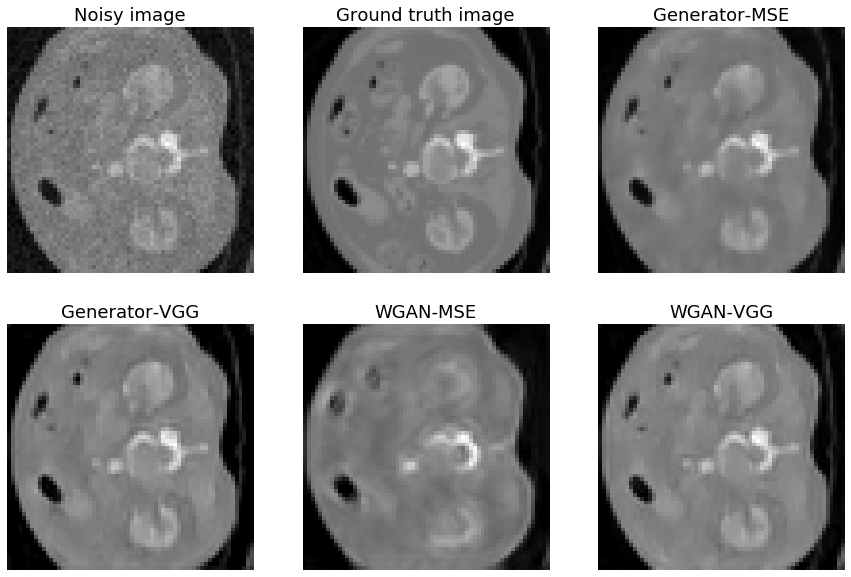

In [41]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes[0, 0].imshow(to_plot[0][0].data.cpu().numpy().reshape(64, 64), cmap='gray')
axes[0, 1].imshow(to_plot[0][-1].data.cpu().numpy().reshape(64, 64), cmap='gray')
axes[0, 2].imshow(to_plot[0][1].data.cpu().numpy().reshape(64, 64), cmap='gray')
axes[1, 0].imshow(to_plot[1][1].data.cpu().numpy().reshape(64, 64), cmap='gray')
axes[1, 1].imshow(to_plot[2][1].data.cpu().numpy().reshape(64, 64), cmap='gray')
axes[1, 2].imshow(to_plot[3][1].data.cpu().numpy().reshape(64, 64), cmap='gray')

axes[0, 0].set_title('Noisy image', fontsize=18)
axes[0, 1].set_title('Ground truth image', fontsize=18)
axes[0, 2].set_title('Generator-MSE', fontsize=18)
axes[1, 0].set_title('Generator-VGG', fontsize=18)
axes[1, 1].set_title('WGAN-MSE', fontsize=18)
axes[1, 2].set_title('WGAN-VGG', fontsize=18)
axes = axes.flatten()
for i in range (len(axes)) : 
    axes[i]
    axes[i].axis('off')
fig.savefig('image_test', dpi = 100, bbox_inches='tight')

In [81]:
import pandas as pd
df = pd.DataFrame.from_dict(dico_metrics)
for col in df.columns :
    df[col] = df[col].apply(lambda x: x[-1])
    df.T

### Computing the mean of our metrics on the validation data

In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(dico_metrics)
for col in df.columns :
    df[col] = df[col].apply(lambda x: np.mean(x))
df.T

,ssim,psnr
generator_alone_mse,0.996717,37.871078
generator_alone_vgg,0.990098,33.325180
generator_wgan_mse,0.985646,31.521484
generator_wgan_vgg,0.994074,35.654411


## Loss function over epochs

In [95]:
loss_gen_alone_mse = np.load('_alone_mse.npy', allow_pickle='TRUE').item()['loss_vgg']['train']
loss_gen_alone_vgg = np.load('_alone_vgg.npy', allow_pickle='TRUE').item()['loss_vgg']['train']
loss_gen_wgan_mse = np.load('_wgan_mse.npy', allow_pickle='TRUE').item()['loss_vgg']['train']
loss_gen_wgan_vgg = np.load('_wgan_vgg.npy', allow_pickle='TRUE').item()['loss_vgg']['train']
loss_disc_wgan_mse = np.load('_wgan_mse.npy', allow_pickle='TRUE').item()
loss_disc_wgan_vgg = np.load('_wgan_vgg.npy', allow_pickle='TRUE').item()

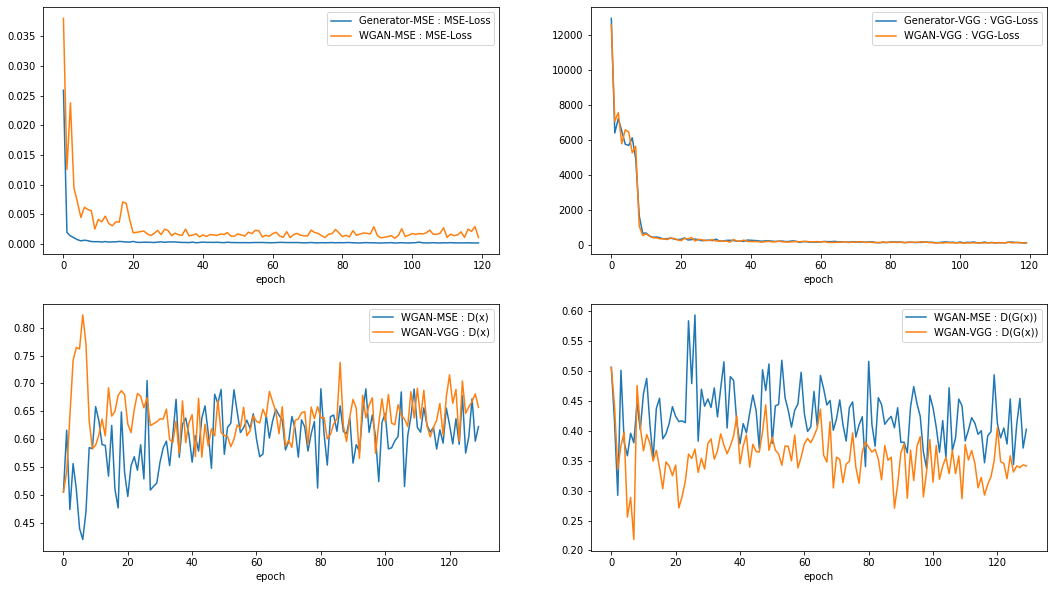

In [96]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.plot(loss_gen_alone_mse[:120], label = 'Generator-MSE : MSE-Loss')
ax1.plot(10*np.array(loss_gen_wgan_mse)[:120], label = 'WGAN-MSE : MSE-Loss')
ax1.legend(loc='best')
ax1.set_xlabel('epoch');

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2.plot(loss_gen_alone_vgg[:120], label = 'Generator-VGG : VGG-Loss')
ax2.plot(10*np.array(loss_gen_wgan_vgg)[:120], label = 'WGAN-VGG : VGG-Loss')
ax2.legend(loc='best')
ax2.set_xlabel('epoch');

ax3 = fig.add_subplot(gs[1, 0]) # row 1, span all columns
ax3.plot(loss_disc_vgg['p_real']['train'][:130], label = 'WGAN-MSE : D(x)')
ax3.plot(loss_disc_wgan['p_real']['train'][:130], label = 'WGAN-VGG : D(x)')
ax3.legend(loc='best')
ax3.set_xlabel('epoch');

ax4 = fig.add_subplot(gs[1, 1]) # row 1, span all columns
ax4.plot(loss_disc_wgan_mse['p_fake']['train'][:130], label = 'WGAN-MSE : D(G(x))')
ax4.plot(loss_disc_wgan_vgg['p_fake']['train'][:130], label = 'WGAN-VGG : D(G(x))')
ax4.legend(loc='best')
ax4.set_xlabel('epoch');

In [47]:
fig.savefig('all_loss.png', dpi =100, bbox_inches='tight')

In [97]:
loss_disc_vgg_al = np.load('_alone_vgg.npy', allow_pickle='TRUE').item()
loss_disc_mse_al = np.load('_alone_mse.npy', allow_pickle='TRUE').item()

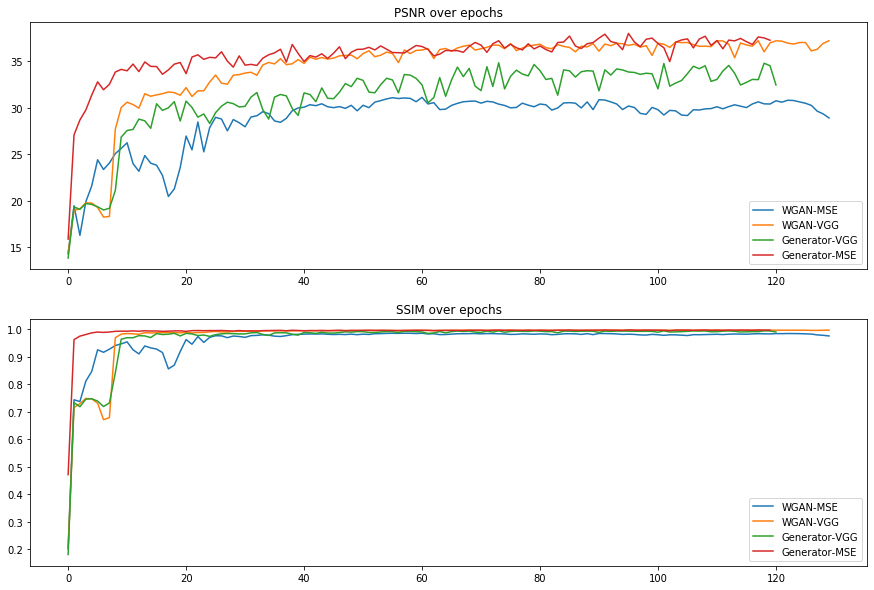

In [99]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))
axes[0].plot(loss_disc_wgan_mse['PSNR']['test'][:130], label = 'WGAN-MSE')
axes[0].plot(loss_disc_wgan_vgg['PSNR']['test'][:130], label = 'WGAN-VGG')
axes[0].plot(loss_disc_vgg_al['PSNR']['train'][:130], label = 'Generator-VGG')
axes[0].plot(loss_disc_mse_al['PSNR']['train'][:130], label = 'Generator-MSE')

axes[1].plot(loss_disc_wgan_mse['SSIM']['test'][:130], label = 'WGAN-MSE')
axes[1].plot(loss_disc_wgan_vgg['SSIM']['test'][:130], label = 'WGAN-VGG')
axes[1].plot(loss_disc_vgg_al['SSIM']['train'][:130], label = 'Generator-VGG')
axes[1].plot(loss_disc_mse_al['SSIM']['train'][:130], label = 'Generator-MSE')
axes[0].set_title('PSNR over epochs')
axes[1].set_title('SSIM over epochs')
axes[0].legend(loc='best')
axes[1].legend(loc='best')

In [100]:
fig.savefig('metrics_epochs.png', dpi =100, bbox_inches='tight')